### Segmentation 04

- Application of 2D and 3D segmentation

In [3]:
%run ../utils.py
import os
import os.path as osp
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cvutils import visualize
from codex import io as codex_io
from codex import config as codex_config
from skimage import exposure
from skimage import measure
from skimage import segmentation

plt.gray()
init_session()

# exp_name = '20180611_D18_PMBC_500G'
# exp_conf_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'config')
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'nodeconv')
# nuc_cyc = 0
# nuc_ch = 0
# mem_cyc = 0
# mem_ch = 2
# #crop = [slice(0, 512), slice(0, 512)]
# crop = [slice(None, None), slice(None, None)]

# exp_name = '7-7-17-multicycle'
# exp_conf_dir = osp.join(os.environ['CODEX_DATA_DIR'], '7-7-17-multicycle')
# #exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], '7-7-17-multicycle-out-none', '1-Processor')
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], '7-7-17-multicycle-out-tf-dynamic-psf', '2-Deconvolution')
# nuc_cyc = 0
# nuc_ch = 0
# mem_cyc = 2
# mem_ch = 1
# crop = [slice(0, 512), slice(0, 512)]
# # #crop = [slice(None, None), slice(None, None)]

exp_name = '20180614_D23_RepA_Tcell_CD4-CD8-DAPI_5by5'
exp_conf_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'config')
#exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], '7-7-17-multicycle-out-none', '1-Processor')
exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'nodeconv')
nuc_cyc = 0
nuc_ch = 0
#crop = [slice(0, 512), slice(0, 512)]
crop = [slice(None, None), slice(None, None)]

model_dir = osp.join(os.environ['CODEX_DATA_DIR'], 'modeling', 'cytopy', 'models', 'nuclei', 'v0.3')
model_path = osp.join(model_dir, 'nuclei_model.h5')

<Figure size 432x288 with 0 Axes>

In [37]:
exp_conf = codex_config.load(exp_conf_dir)

In [38]:
tile = codex_io.read_tile(osp.join(exp_data_dir, 'reg001_X01_Y01.tif'), exp_conf)
tile = tile[:, :, :, crop[0], crop[1]]
tile.shape, tile.dtype

((1, 35, 3, 1008, 1344), dtype('uint8'))

In [39]:
if tile.dtype == np.uint16:
    tile = exposure.rescale_intensity(tile, in_range=np.uint16, out_range=np.uint8).astype(np.uint8)

In [40]:
exp_conf.channel_names[:10]

['DAPI', 'CD4', 'CD8']

In [41]:
img_nuc = tile[nuc_cyc, :, nuc_ch]
# plt.imshow(img_nuc)
# plt.gcf().set_size_inches(12, 12)
img_nuc.shape, img_nuc.dtype

((35, 1008, 1344), dtype('uint8'))

In [82]:
from codex.cytometry import cytometer
import imp
imp.reload(cytometer)

<module 'codex.cytometry.cytometer' from '/lab/repos/codex/python/pipeline/codex/cytometry/cytometer.py'>

In [83]:
#cytom = cytometer.Cytometer3D(img_nuc.shape[1:] + (1,), model_path).initialize()
cytom = cytometer.Cytometer2D(img_nuc.shape[1:] + (1,), model_path).initialize()

In [84]:
%%time
#img_seg, img_pred, img_bin = cytom.segment(img_nuc)
#img_seg, img_pred, img_bin = cytom.segment(img_nuc, best_z=15, batch_size=8)
img_seg, img_pred, img_bin = cytom.segment(img_nuc, batch_size=8)

CPU times: user 36.2 s, sys: 3.3 s, total: 39.5 s
Wall time: 39.2 s


In [86]:
img_seg_props = measure.regionprops(img_seg)
pd.Series([img_seg_props[i].filled_image.shape[0] for i in range(len(img_seg_props))]).value_counts()

In [87]:
# Use find boundaries in 2D because it seems buggy in 3D

#img_border = segmentation.find_boundaries(img_seg, mode='inner', background=img_seg.min())

img_border = np.stack([
    segmentation.find_boundaries(img_seg[i], mode='inner', background=img_seg.min())
    for i in range(img_nuc.shape[0])
], axis=0)
img_border.shape

(35, 1008, 1344)

In [88]:
img_nuc_border = img_nuc.copy()
img_nuc_border = exposure.rescale_intensity(img_nuc_border, out_range=(0, 200)).astype(np.uint8)
img_nuc_border[img_bin[..., 2] > 0] = 230
#img_nuc_border[img_bin[..., 1] > 0] = 90
img_nuc_border[img_border > 0] = 255
img_nuc_border[img_seg == 0] = 0
img_nuc_border.dtype

dtype('uint8')

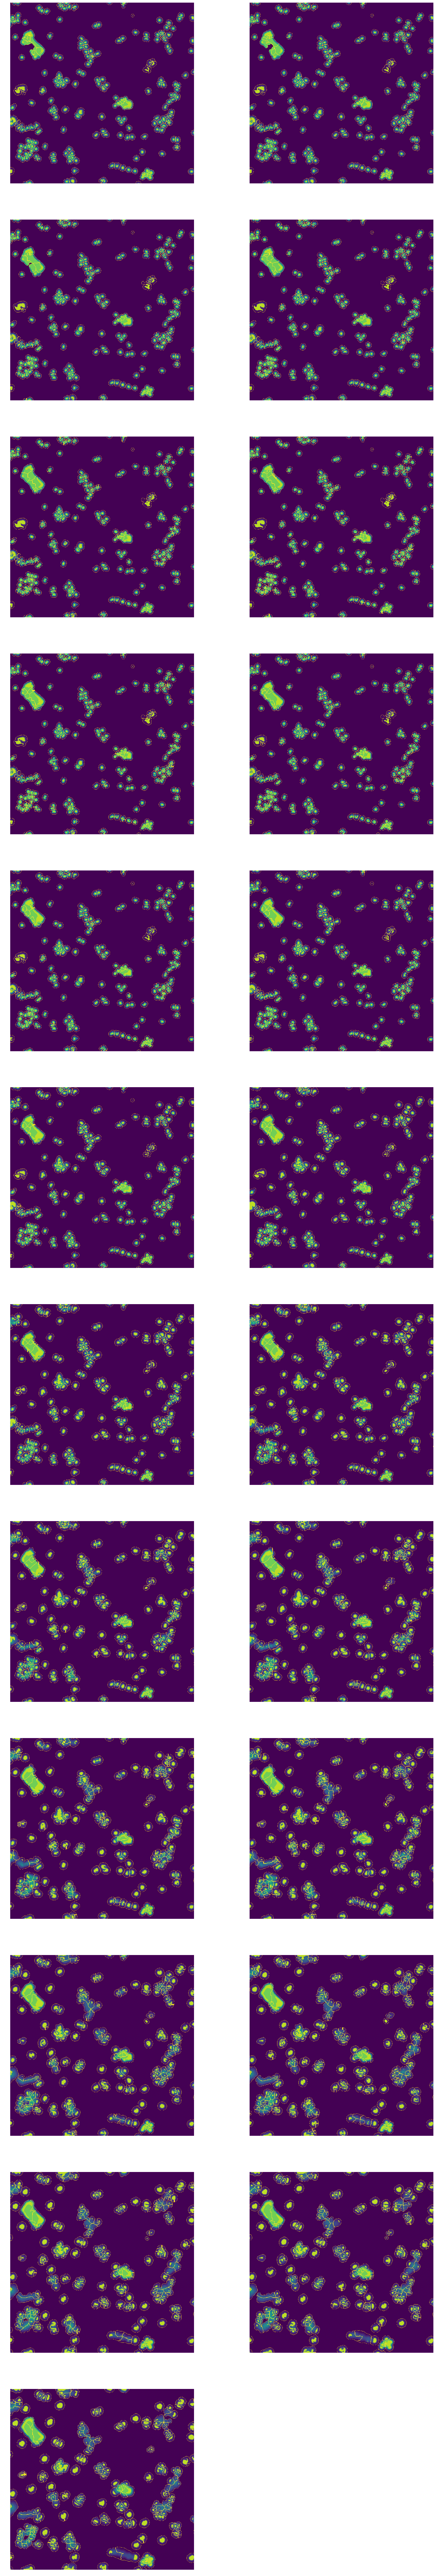

In [89]:
crop = [slice(0, 1024), slice(0, 1024)]
visualize.display_images([
    img_nuc_border[i][crop]
    #img_pred[i][crop].astype(float) 
    for i in range(12, img_nuc_border.shape[0])
], size=30, cols=2, cmap='viridis')

In [90]:
df = cytom.quantify(tile, img_seg)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11293 entries, 0 to 11292
Data columns (total 8 columns):
id        11293 non-null int64
x         11293 non-null float64
y         11293 non-null float64
z         11293 non-null int64
size      11293 non-null int64
ch:000    11293 non-null float64
ch:001    11293 non-null float64
ch:002    11293 non-null float64
dtypes: float64(5), int64(3)
memory usage: 705.9 KB


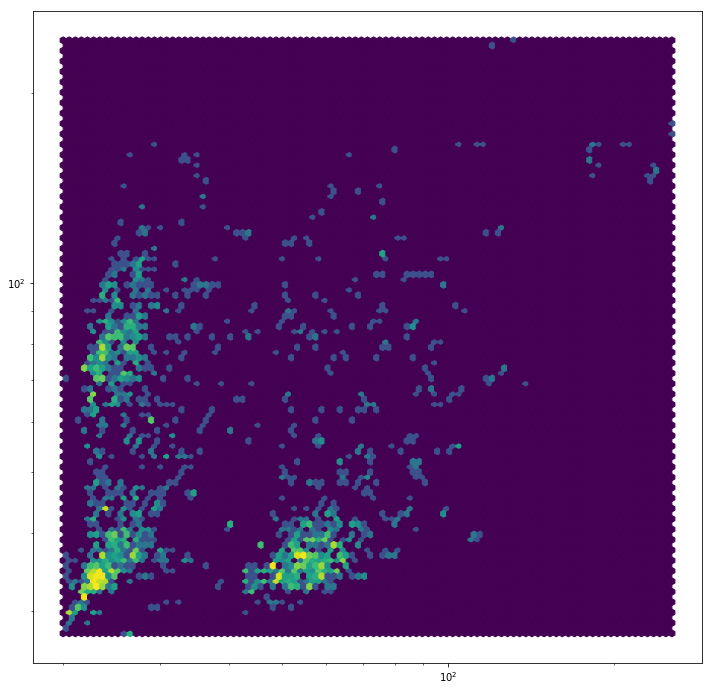

In [93]:
dfp = df[df['z'].between(13, 18)]
plt.hexbin(dfp['ch:001'], dfp['ch:002'], bins='log', xscale='log', yscale='log', cmap='viridis')
plt.gcf().set_size_inches(12, 12)